#**Skin Disease Classification**

Skin diseases are prevalent worldwide and can have a significant impact on a person's quality of life. Timely and accurate diagnosis of these conditions is essential for effective treatment and management. With advances in machine learning and computer vision, the development of reliable models for skin disease classification has become possible.

The main objective of this project is to create a classification model for skin diseases using the [DermNet](https://www.kaggle.com/datasets/shubhamgoel27/dermnet) dataset. The DermNet dataset provides a comprehensive collection of images representing various dermatological conditions. By leveraging this dataset, we aim to develop a model that can accurately classify skin diseases based on input images.

# About Dataset

The dataset used in this project includes a collection of images depicting 23 different types of skin diseases sourced from [DermNet](https://dermnetnz.org/) and have been collected [here](https://www.kaggle.com/datasets/shubhamgoel27/dermnet). The dataset contains a total of approximately 19.5k images, which have been divided into a training set of around 15k images and a separate test set.

# Downloading the Dataset

In [1]:
# Install Kaggle library
!pip install -q kaggle

# Create directory for the Kaggle API key
!mkdir ~/.kaggle

# Create directory to store the DermNet dataset
!mkdir dermnet

# Prerequisite: Upload your Kaggle API key (kaggle.json)
# Make sure you have obtained the API key from Kaggle (https://www.kaggle.com/docs/api#getting-started-installation-&-authentication)

# Copy the Kaggle API key to the appropriate directory
!cp kaggle.json ~/.kaggle

# Set appropriate permissions for the Kaggle API key
!chmod 600 ~/.kaggle/kaggle.json

# Download the DermNet dataset using the Kaggle API
!kaggle datasets download -d 'shubhamgoel27/dermnet'

100% 1.72G/1.72G [01:21<00:00, 24.9MB/s]
100% 1.72G/1.72G [01:21<00:00, 22.6MB/s]


# Data Extraction

In [2]:
# Import the necessary library for handling zip files
import zipfile

# Specify the name of the downloaded dataset zip file
dataset_zip = zipfile.ZipFile('dermnet.zip', 'r')

# Extract the contents of the zip file to the specified directory
dataset_zip.extractall('dermnet')

# Close the zip file after extraction
dataset_zip.close()

# Dataset Examination

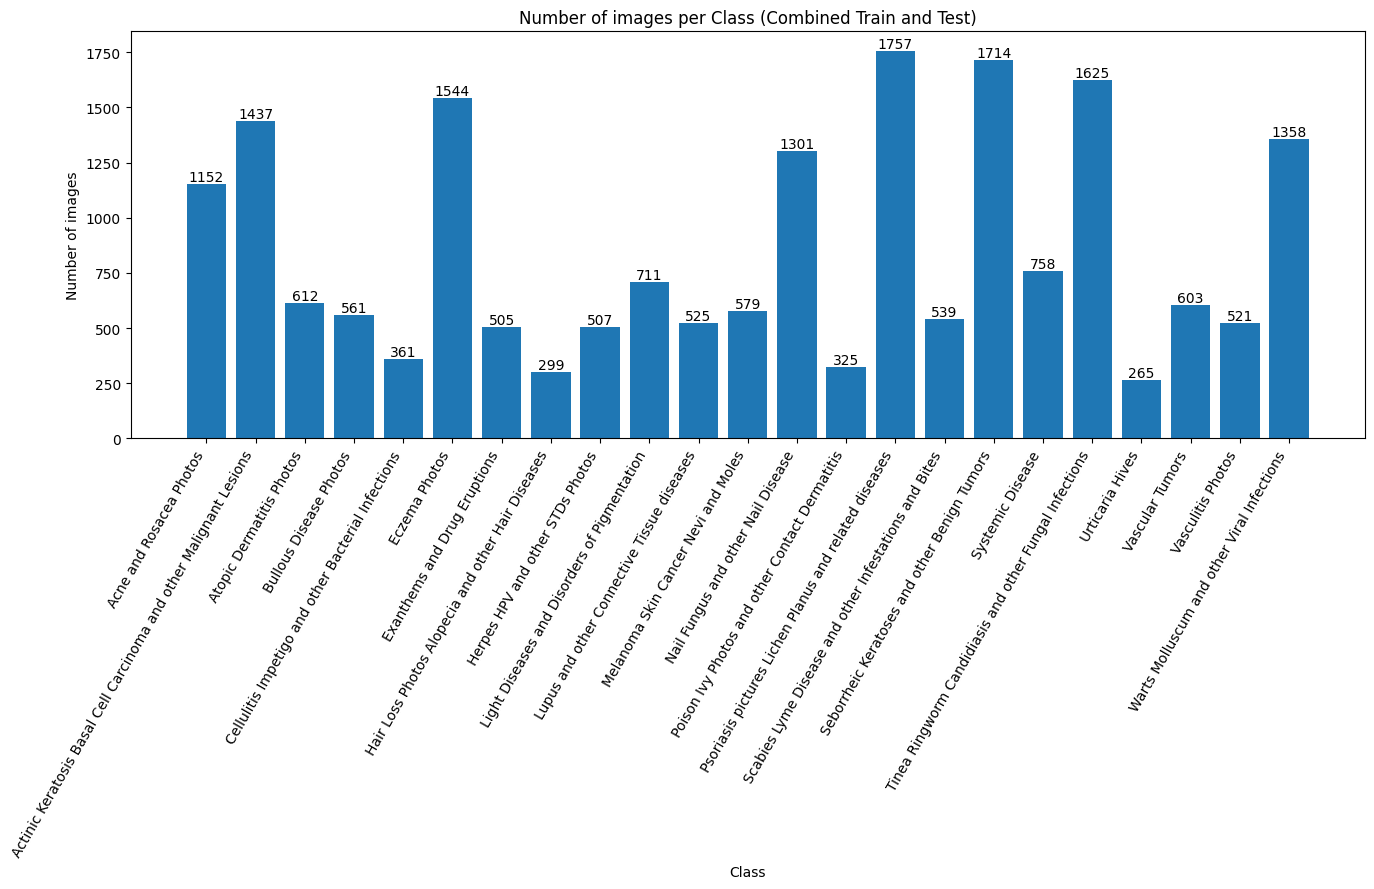

In [3]:
import os
import matplotlib.pyplot as plt

# Set the path to the dataset directory
dataset_dir = 'dermnet'

# Set the path to the train and test directories
train_dir = os.path.join(dataset_dir, 'train')
test_dir = os.path.join(dataset_dir, 'test')

# Get the list of class names (assuming each subdirectory represents a class)
class_names = sorted(os.listdir(train_dir))

# Initialize lists to store the number of images for each class
train_data_counts = []
test_data_counts = []

# Iterate over each class
for class_name in class_names:
    # Count the number of images in the train directory for the current class
    train_class_dir = os.path.join(train_dir, class_name)
    train_data_count = len(os.listdir(train_class_dir))
    train_data_counts.append(train_data_count)

    # Count the number of images in the test directory for the current class
    test_class_dir = os.path.join(test_dir, class_name)
    test_data_count = len(os.listdir(test_class_dir))
    test_data_counts.append(test_data_count)

# Combine the train and test data counts for each class
combined_data_counts = [train_count + test_count for train_count, test_count in zip(train_data_counts, test_data_counts)]

# Create a larger bar plot for each class with the combined data counts
plt.figure(figsize=(14, 9))
plt.bar(class_names, combined_data_counts)
plt.xlabel('Class')
plt.ylabel('Number of images')
plt.title('Number of images per Class (Combined Train and Test)')
plt.xticks(rotation=60, ha='right')

# Add the number of images as text above each bar
for i, count in enumerate(combined_data_counts):
    plt.text(i, count, str(count), ha='center', va='bottom')

# Display the plot
plt.tight_layout()
plt.show()

> The dataset comprises images of various skin diseases, with a total of 23 classes. Upon examining the data, it is evident that there is an imbalance in the distribution of images across the classes. This imbalance can potentially affect the performance of the classification model.

> In an imbalanced dataset, some classes may have significantly fewer samples compared to others. This can lead to biased model training, where the model may not effectively learn to classify the minority classes. By oversampling, we increase the number of samples in the minority classes to balance the dataset.

# Oversampling and Splitting Data

In [4]:
import random
import shutil

def count_images(folder):
    """
    Count the number of images in a folder.

    Args:
        folder (str): Path to the folder.

    Returns:
        int: Number of images in the folder.
    """
    count = 0
    for _, _, files in os.walk(folder):
        count += len(files)
    return count

def oversample(folder, target_count):
    """
    Oversample the images in a folder to reach a target count.

    Args:
        folder (str): Path to the folder.
        target_count (int): Target number of images in the folder.
    """
    image_files = os.listdir(folder)
    current_count = len(image_files)
    oversample_count = target_count - current_count

    while oversample_count > 0:
        random_file = random.choice(image_files)
        source = os.path.join(folder, random_file)
        new_file = os.path.splitext(random_file)[0] + '_oversampled' + os.path.splitext(random_file)[1]
        destination = os.path.join(folder, new_file)
        shutil.copy(source, destination)
        image_files.append(new_file)
        oversample_count -= 1

def move_images(source_folder, destination_folder, count):
    """
    Move a specified number of random images from a source folder to a destination folder.

    Args:
        source_folder (str): Path to the source folder.
        destination_folder (str): Path to the destination folder.
        count (int): Number of images to move.
    """
    images = random.sample(os.listdir(source_folder), count)
    for image in images:
        source = os.path.join(source_folder, image)
        destination = os.path.join(destination_folder, image)
        shutil.move(source, destination)

def preprocess_dataset(training_dir, output_dir):
    """
    Preprocess the dataset by combining class folders, oversampling, and splitting into train, validation, and test sets.

    Args:
        training_dir (str): Path to the training directory.
        output_dir (str): Path to the output directory.
    """
    combined_dir = os.path.join(output_dir, 'combined')
    os.makedirs(combined_dir, exist_ok=True)

    # Combine class folders into a single 'combined' folder
    for folder in [training_dir, test_dir]:
        class_folders = os.listdir(folder)
        for class_folder in class_folders:
            src = os.path.join(folder, class_folder)
            dst = os.path.join(combined_dir, class_folder)
            shutil.copytree(src, dst, dirs_exist_ok=True)

    # Remove class folders with less than 1300 images
    for class_folder in os.listdir(combined_dir):
        class_folder_path = os.path.join(combined_dir, class_folder)
        if count_images(class_folder_path) < 1300:
            shutil.rmtree(class_folder_path)

    # Oversample the remaining class folders to have 2000 images each
    for class_folder in os.listdir(combined_dir):
        class_folder_path = os.path.join(combined_dir, class_folder)
        oversample(class_folder_path, 2000)

    # Split the data into train, validation, and test sets with a ratio of 8:1:1
    train_ratio = 8
    validation_ratio = 1
    test_ratio = 1

    train_folder = os.path.join(output_dir, 'train')
    validation_folder = os.path.join(output_dir, 'validation')
    test_folder = os.path.join(output_dir, 'test')

    os.makedirs(train_folder, exist_ok=True)
    os.makedirs(validation_folder, exist_ok=True)
    os.makedirs(test_folder, exist_ok=True)

    # Move images from the combined folder to the train, validation, and test folders
    for class_folder in os.listdir(combined_dir):
        class_folder_path = os.path.join(combined_dir, class_folder)
        train_count = int(count_images(class_folder_path) * train_ratio / (train_ratio + validation_ratio + test_ratio))
        validation_count = int(count_images(class_folder_path) * validation_ratio / (train_ratio + validation_ratio + test_ratio))
        test_count = count_images(class_folder_path) - train_count - validation_count

        train_class_folder = os.path.join(train_folder, class_folder)
        validation_class_folder = os.path.join(validation_folder, class_folder)
        test_class_folder = os.path.join(test_folder, class_folder)

        os.makedirs(train_class_folder, exist_ok=True)
        os.makedirs(validation_class_folder, exist_ok=True)
        os.makedirs(test_class_folder, exist_ok=True)

        move_images(class_folder_path, train_class_folder, train_count)
        move_images(class_folder_path, validation_class_folder, validation_count)
        move_images(class_folder_path, test_class_folder, test_count)

    # Remove the combined folder
    shutil.rmtree(combined_dir)

training_dir = 'dermnet/train'
test_dir = 'dermnet/test'
output_dir = 'dataset'

preprocess_dataset(training_dir, output_dir)

> Classes with very few samples, such as those with fewer than 1300 images, may not provide sufficient data for the model to learn robust and meaningful patterns or features. By removing classes with fewer samples, we focus on classes with a more substantial amount of data, which can improve the model's ability to learn and generalize.

> In this case, we are oversampling the classes to have 2000 images each, ensuring a more balanced representation of the classes in the dataset.

> We also do splitting data. The 8:1:1 ratio is commonly used for splitting a dataset into train, validation, and test sets. The larger portion is allocated to the training set (80%) to provide enough data for the model to learn the underlying patterns. The validation set (10%) is used for tuning hyperparameters and evaluating model performance during training. The remaining portion is used as the test set (10%) to assess the model's final performance on unseen data.

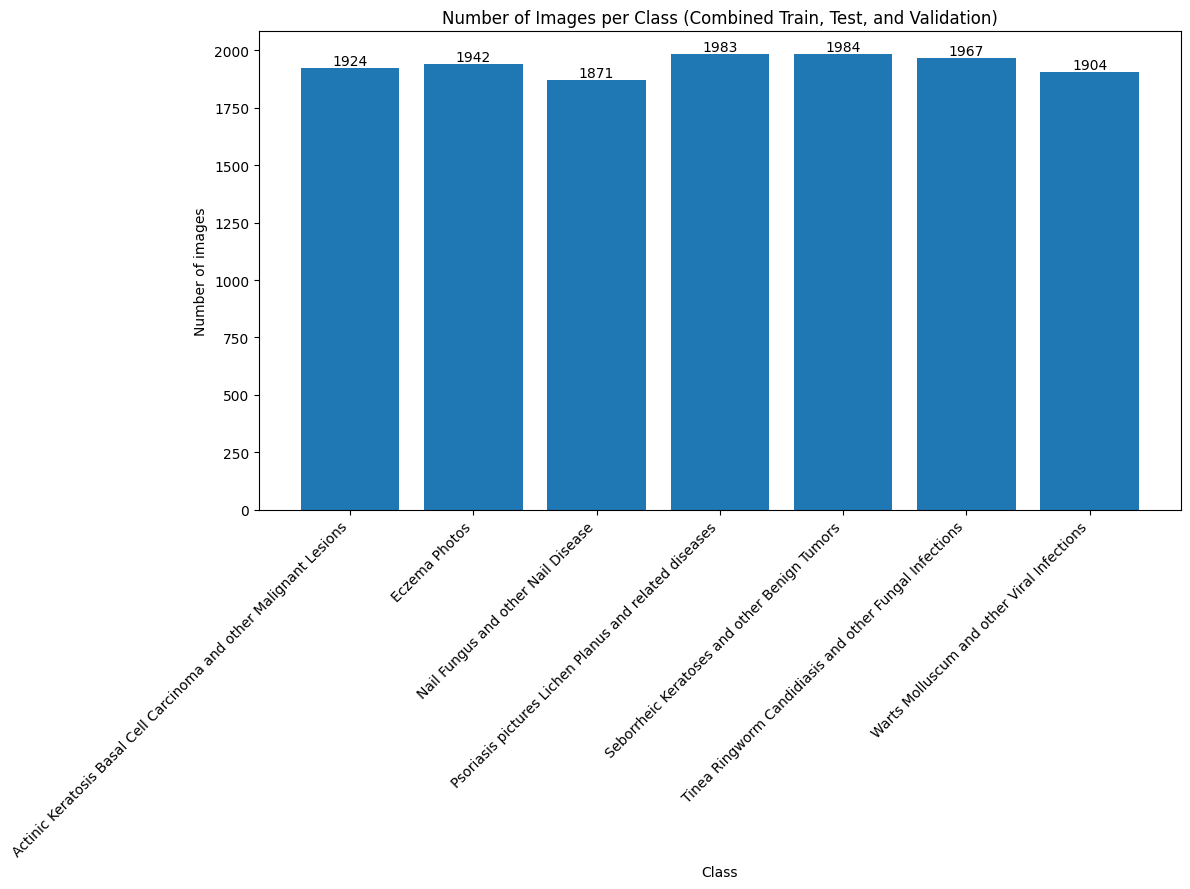

In [5]:
# Set the path to the dataset directory
dataset_dir = 'dataset'

# Set the path to the train, test, and validation directories
train_dir = os.path.join(dataset_dir, 'train')
test_dir = os.path.join(dataset_dir, 'test')
validation_dir = os.path.join(dataset_dir, 'validation')

# Get the list of class names (assuming each subdirectory represents a class)
class_names = sorted(os.listdir(train_dir))

# Initialize lists to store the number of images for each class
train_data_counts = []
test_data_counts = []
validation_data_counts = []

# Iterate over each class
for class_name in class_names:
    # Count the number of images in the train directory for the current class
    train_class_dir = os.path.join(train_dir, class_name)
    train_data_count = len(os.listdir(train_class_dir))
    train_data_counts.append(train_data_count)

    # Count the number of images in the test directory for the current class
    test_class_dir = os.path.join(test_dir, class_name)
    test_data_count = len(os.listdir(test_class_dir))
    test_data_counts.append(test_data_count)

    # Count the number of images in the validation directory for the current class
    validation_class_dir = os.path.join(validation_dir, class_name)
    validation_data_count = len(os.listdir(validation_class_dir))
    validation_data_counts.append(validation_data_count)

# Combine the train, test, and validation data counts for each class
combined_data_counts = [train_count + test_count + validation_count for train_count, test_count, validation_count in zip(train_data_counts, test_data_counts, validation_data_counts)]

# Create a larger bar plot for each class with the combined data counts
plt.figure(figsize=(12, 9))
plt.bar(class_names, combined_data_counts)
plt.xlabel('Class')
plt.ylabel('Number of images')
plt.title('Number of Images per Class (Combined Train, Test, and Validation)')
plt.xticks(rotation=45, ha='right')

# Add the number of images as text above each bar
for i, count in enumerate(combined_data_counts):
    plt.text(i, count, str(count), ha='center', va='bottom')

# Display the plot
plt.tight_layout()
plt.show()


> As seen from the data above, the dataset becomes more balanced with each class having almost 2000 image data. now, the dataset is ready to be used for the next process, which is data augmentation.

# Data Augmentation

> Data augmentation is necessary to increase the diversity and quantity of the training data. By applying various transformations and modifications to the existing images, data augmentation helps expose the model to a wider range of scenarios, variations, and patterns.

> This allows the model to learn robust features and become more resilient to noise, variations in lighting, different orientations, and other real-world conditions. Data augmentation is especially crucial in domains with limited training data, as it effectively expands the dataset and reduces the risk of overfitting, leading to improved generalization and overall model performance.

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Path to the dataset folder
dataset_path = 'dataset'

# Get the paths to the train, validation, and test folders
train_folder = os.path.join(dataset_path, 'train')
validation_folder = os.path.join(dataset_path, 'validation')
test_folder = os.path.join(dataset_path, 'test')

def train_val_generators():
    # Define the image data generators for training and validation
    train_datagen = ImageDataGenerator(
            rotation_range=30,
            brightness_range=[0.9, 1.3],
            zoom_range=0.3,
            horizontal_flip=True,
            vertical_flip=True,
            fill_mode='nearest',
            rescale=1./255
    )

    validation_datagen = ImageDataGenerator(rescale=1./255)

    # Create the generator objects for training and validation data
    train_generator = train_datagen.flow_from_directory(
        train_folder,
        target_size=(224, 224),
        batch_size=64,
        class_mode='categorical'
    )

    validation_generator = validation_datagen.flow_from_directory(
        validation_folder,
        target_size=(224, 224),
        batch_size=16,
        class_mode='categorical'
    )

    return train_generator, validation_generator

train_generator, validation_generator = train_val_generators()


Found 10857 images belonging to 7 classes.
Found 1355 images belonging to 7 classes.


# Model Building and Architecture Configuration

In [7]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [8]:
# Load the DenseNet121 model pretrained on ImageNet
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the weights of the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Build the custom classification layers on top of the pre-trained base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(32, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(7, activation='softmax')(x)

# Create the final model by specifying the input and output layers
model = Model(inputs=base_model.input, outputs=predictions)

model.summary()

29084464/29084464 [==============================] - 2s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                             

> We use transfer learning technique to train the data. Transfer learning is a valuable approach in this context due to its ability to leverage pre-trained models, such as DenseNet121. By utilizing a pre-trained model, we can benefit from the knowledge and representations it has learned from a vast dataset like ImageNet. This saves computational resources and time, especially when working with limited labeled data. DenseNet121 is specifically chosen as the base model because of its effectiveness in capturing intricate image features. Its deep hierarchical structure and powerful convolutional layers enable the model to extract meaningful representations from the skin disease images, leading to better classification performance.

> In addition to the base model, extra layers are incorporated to further refine the learned representations and improve classification. The global average pooling layer reduces the dimensionality of the feature maps, making the model more compact. The dense layer introduces non-linearity and captures complex relationships between features. Batch normalization stabilizes and speeds up the training process, while dropout prevents overfitting by randomly deactivating neurons during training. These additional layers enhance the model's expressiveness and flexibility, enabling it to learn more nuanced and discriminative representations. By combining the power of DenseNet121 with these supplementary layers, the model becomes more capable of capturing high-level abstractions and achieving superior performance in classifying skin disease images.

# Training Model

In [9]:
# Compile the model with Adam optimizer, a learning rate of 1e-3, categorical crossentropy loss, and accuracy metric
model.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

# Set up early stopping to monitor validation loss, with a minimum change of 0.001 and a patience of 2 epochs
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=2, restore_best_weights=True)

# Train the model using the training generator and validate using the validation generator
# Set a maximum of 15 epochs and include the early stopping callback
history = model.fit(train_generator, epochs=15, validation_data=validation_generator, callbacks=[early_stopping])

Epoch 1/15
170/170 [==============================] - 244s 1s/step - loss: 2.1873 - accuracy: 0.3426 - val_loss: 1.7133 - val_accuracy: 0.4605
Epoch 2/15
170/170 [==============================] - 229s 1s/step - loss: 1.7637 - accuracy: 0.4052 - val_loss: 1.5773 - val_accuracy: 0.4893
Epoch 3/15
170/170 [==============================] - 222s 1s/step - loss: 1.6338 - accuracy: 0.4425 - val_loss: 1.5144 - val_accuracy: 0.4893
Epoch 4/15
170/170 [==============================] - 220s 1s/step - loss: 1.5754 - accuracy: 0.4603 - val_loss: 1.4027 - val_accuracy: 0.5402
Epoch 5/15
170/170 [==============================] - 229s 1s/step - loss: 1.5237 - accuracy: 0.4639 - val_loss: 1.4089 - val_accuracy: 0.5070
Epoch 6/15
170/170 [==============================] - 218s 1s/step - loss: 1.5084 - accuracy: 0.4627 - val_loss: 1.3638 - val_accuracy: 0.5306
Epoch 7/15
170/170 [==============================] - 220s 1s/step - loss: 1.4896 - accuracy: 0.4769 - val_loss: 1.3578 - val_accuracy: 0.5137

> We train the model with the EarlyStopping callback to prevent overfitting and ensure efficient model training. By monitoring the validation loss, the callback allows us to halt the training if there is no significant improvement in the model's performance, thus avoiding excessive training that could lead to overfitting. The choice of the Adam optimizer with a learning rate of 1e-3, categorical cross-entropy loss, and accuracy metric is based on their effectiveness in training neural networks.

> The Adam optimizer combines adaptive learning rates and momentum, leading to faster convergence and improved performance. The categorical cross-entropy loss function is well-suited for multi-class classification tasks, while the accuracy metric provides a measure of the model's classification performance. Incorporating these strategies and callbacks in the training process aims to optimize the model's performance, ensure generalization to unseen data, and mitigate the risk of overfitting, making the training process more effective and reliable.

# Fine Tuning

In [10]:
# Make the base model trainable
for layer in base_model.layers:
    layer.trainable = True

# Compile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Define the EarlyStopping and ReduceLROnPlateau callbacks
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=1e-9)

# Train the model with the defined callbacks
history = model.fit(train_generator, epochs=50, validation_data=validation_generator, callbacks=[early_stopping, reduce_lr])

Epoch 1/50
170/170 [==============================] - 336s 2s/step - loss: 1.4227 - accuracy: 0.4988 - val_loss: 1.9781 - val_accuracy: 0.3446 - lr: 1.0000e-04
Epoch 2/50
170/170 [==============================] - 254s 1s/step - loss: 1.2092 - accuracy: 0.5990 - val_loss: 1.2821 - val_accuracy: 0.5624 - lr: 1.0000e-04
Epoch 3/50
170/170 [==============================] - 262s 2s/step - loss: 1.0843 - accuracy: 0.6521 - val_loss: 1.2091 - val_accuracy: 0.5830 - lr: 1.0000e-04
Epoch 4/50
170/170 [==============================] - 255s 1s/step - loss: 0.9742 - accuracy: 0.6960 - val_loss: 0.9504 - val_accuracy: 0.7092 - lr: 1.0000e-04
Epoch 5/50
170/170 [==============================] - 248s 1s/step - loss: 0.8821 - accuracy: 0.7303 - val_loss: 0.9009 - val_accuracy: 0.7026 - lr: 1.0000e-04
Epoch 6/50
170/170 [==============================] - 247s 1s/step - loss: 0.8064 - accuracy: 0.7618 - val_loss: 0.8686 - val_accuracy: 0.7026 - lr: 1.0000e-04
Epoch 7/50
170/170 [====================

> By performing fine-tuning with the given configuration and incorporating the EarlyStopping and ReduceLROnPlateau callbacks, we aim to achieve further improvement in the model's performance while mitigating the risk of overfitting. Fine-tuning allows the model to adapt the pre-trained DenseNet121 network to our specific skin disease classification task, leveraging the learned representations to capture disease-related features more effectively.

> The EarlyStopping callback is crucial for preventing overfitting by monitoring the validation loss and stopping the training if no significant improvement is observed. This helps to avoid excessive training that could lead to the model memorizing the training data without generalizing well to unseen data.

> Additionally, the ReduceLROnPlateau callback dynamically adjusts the learning rate during training, reducing it when the validation loss plateaus. This adaptive learning rate strategy allows the model to make smaller updates and fine-tune the parameters more precisely, leading to better convergence and potentially higher performance. Overall, the combination of fine-tuning, EarlyStopping, and ReduceLROnPlateau callbacks provides an effective approach to optimize the model's performance while maintaining good generalization and preventing overfitting.

# Model Evaluation

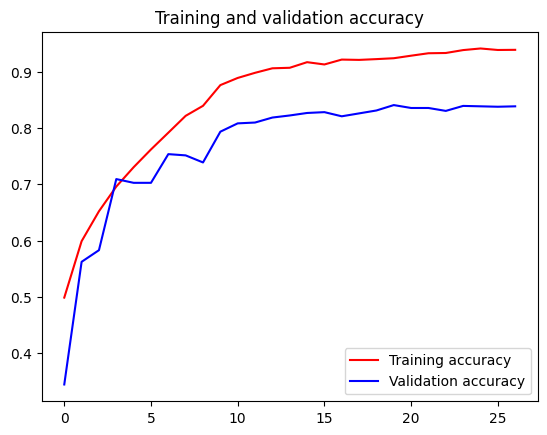

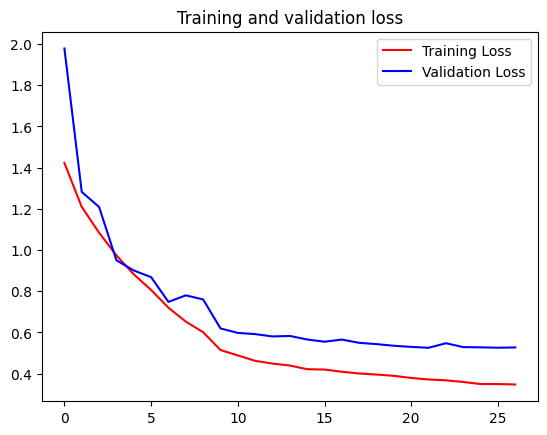

In [11]:
# Plot the chart for accuracy and loss on both training and validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [15]:
# Path to the test dataset folder
test_folder = 'dataset/test'

# Generate the test dataset
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_folder,
        target_size=(224, 224),
        batch_size=16,
        class_mode='categorical',
        shuffle=False
    )

Found 1363 images belonging to 7 classes.


In [16]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Generate predictions on the test set
predictions = model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)

# Get the true labels
true_labels = test_generator.classes

# Print the classification report
print(classification_report(true_labels, predicted_labels))

# Print the confusion matrix
print(confusion_matrix(true_labels, predicted_labels))

86/86 [==============================] - 13s 146ms/step
              precision    recall  f1-score   support

           0       0.89      0.82      0.85       193
           1       0.76      0.84      0.80       195
           2       0.87      0.90      0.89       188
           3       0.77      0.67      0.72       199
           4       0.85      0.80      0.82       199
           5       0.84      0.85      0.84       198
           6       0.83      0.91      0.87       191

    accuracy                           0.83      1363
   macro avg       0.83      0.83      0.83      1363
weighted avg       0.83      0.83      0.83      1363

[[159   7   1   3  12   4   7]
 [  2 164   2  10   4   9   4]
 [  1   2 170  10   0   3   2]
 [  4  21  18 134   5   8   9]
 [ 12   8   3   2 159   5  10]
 [  1  11   0   9   5 168   4]
 [  0   4   2   5   3   3 174]]


# Save Model

In [ ]:
model.save('skinDiseaseClassification.h5')